# Day 06: Programming Tips, Application: Nonlinear Least Squares

---


In [2]:
import grama as gr
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
DF = gr.Intention()

# Set figure options
plt.rcParams['figure.figsize'] = [6, 6] # Need square aspect ratio for gradients to appear normal
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower


## Linear vs Nonlinear

---


In [19]:
md_linear = (
    gr.Model("Linear, in the parameters a, n")
    >> gr.cp_function(
        fun=lambda x, a, n: a * x + n * x**3,
        var=["x", "a", "n"],
        out=["f"],
    )
    >> gr.cp_bounds(
        x=(-1, +1),
        a=(-1, +1),
        n=( 1,  4),
    )
)

md_nonlinear = (
    gr.Model("Nonlinear, in the parameters a, n")
    >> gr.cp_function(
        fun=lambda x, a, n: n*(x - a)**2,
        var=["x", "a", "n"],
        out=["f"],
    )
    >> gr.cp_bounds(
        x=(-1, +1),
        a=(-1, +1),
        n=( 1,  4),
    )
)

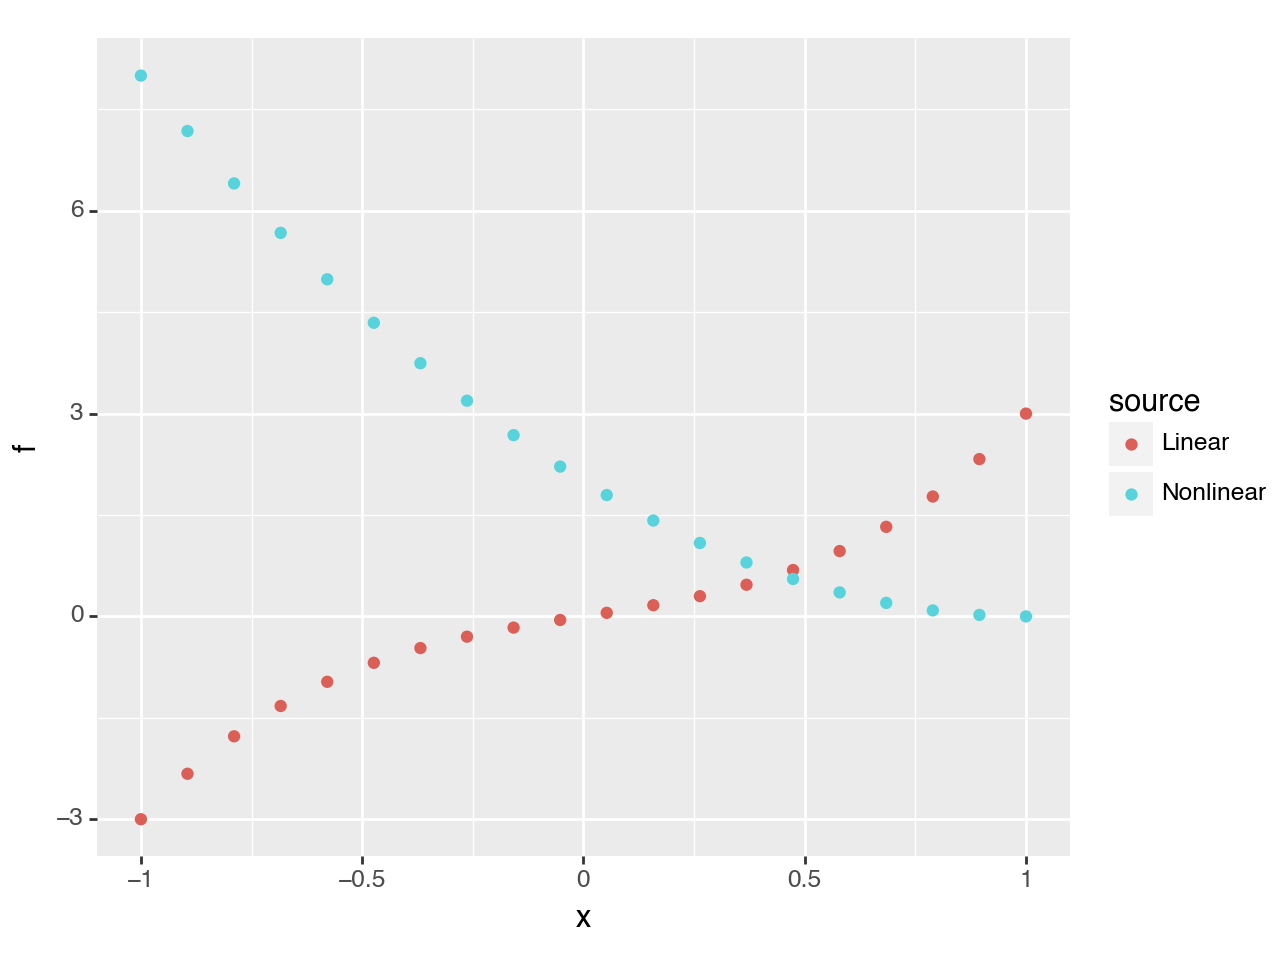

<Figure Size: (640 x 480)>

In [20]:
df_param_true = gr.df_make(a=1, n=2)

df_data = (
    gr.eval_df(
        md_linear, 
        df=gr.tran_outer(
            df_param_true,
            gr.df_make(x=gr.linspace(-1, +1, 20), source="Linear"),
        )
    )
    >> gr.tf_bind_rows(
        gr.eval_df(
            md_nonlinear, 
            df=gr.tran_outer(
                df_param_true,
                gr.df_make(x=gr.linspace(-1, +1, 20), source="Nonlinear"),
            )
        )
    )
    >> gr.tf_select("x", "f", "source")
)

(
    df_data
    >> gr.ggplot(gr.aes("x", "f", color="source"))
    + gr.geom_point()
)

In [21]:
(
    df_data
    >> gr.tf_filter(DF["source"] == "Linear")
    >> gr.ft_nls(
        md=md_linear,
    )
)

... fit_nls setting out = ['f']
... eval_nls setting var_fix = []
... eval_nls setting var_feat = {'x'}
Estimated runtime: 0.0000 sec
     a         n  a_0  n_0  success  \
0  1.0  1.999998  0.0  2.5     True   

                                            message  n_iter           mse  
0  CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL       8  1.180876e-12  


model: Linear, in the parameters a, n (Fitted)

  inputs:
    var_det:
      x: (unbounded)

    var_rand:

    copula:
      None

  functions:
      Fix variable levels: ['x'] -> ['a', 'n']
      Linear, in the parameters a, n: ['a', 'n', 'x'] -> ['f']

In [22]:
(
    df_data
    >> gr.tf_filter(DF["source"] == "Nonlinear")
    >> gr.ft_nls(
        md=md_nonlinear,
    )
)

... fit_nls setting out = ['f']
... eval_nls setting var_fix = []
... eval_nls setting var_feat = {'x'}
Estimated runtime: 0.0000 sec
     a         n  a_0  n_0  success  \
0  1.0  2.000001  0.0  2.5     True   

                                            message  n_iter           mse  
0  CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL      12  2.786669e-13  


model: Nonlinear, in the parameters a, n (Fitted)

  inputs:
    var_det:
      x: (unbounded)

    var_rand:

    copula:
      None

  functions:
      Fix variable levels: ['x'] -> ['a', 'n']
      Nonlinear, in the parameters a, n: ['a', 'n', 'x'] -> ['f']

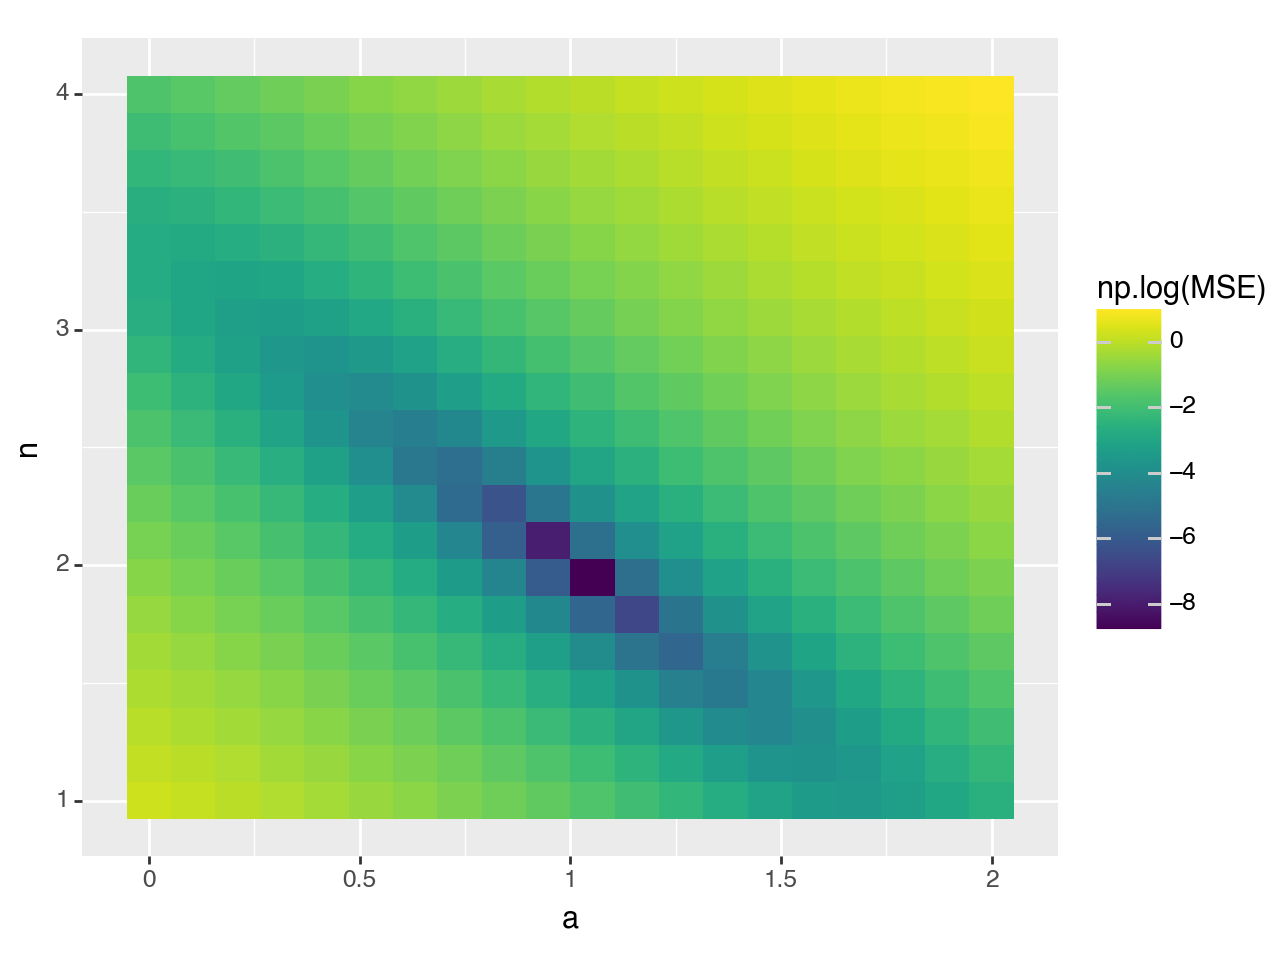

<Figure Size: (640 x 480)>

In [48]:
(
    md_linear
    >> gr.ev_df(
        df=gr.tran_outer(
            df_data 
            >> gr.tf_filter(DF["source"] == "Linear")
            >> gr.tf_rename(f_hat="f"),
            gr.df_grid(a=np.linspace(0, +2, 20), n=np.linspace(1, 4, 20))
        )
    )
    >> gr.tf_group_by(DF["a"], DF["n"])
    >> gr.tf_summarize(
        MSE=gr.mse(DF["f_hat"], DF["f"])
    )

    >> gr.ggplot(gr.aes("a", "n"))
    + gr.geom_tile(gr.aes(fill="np.log(MSE)"))
)

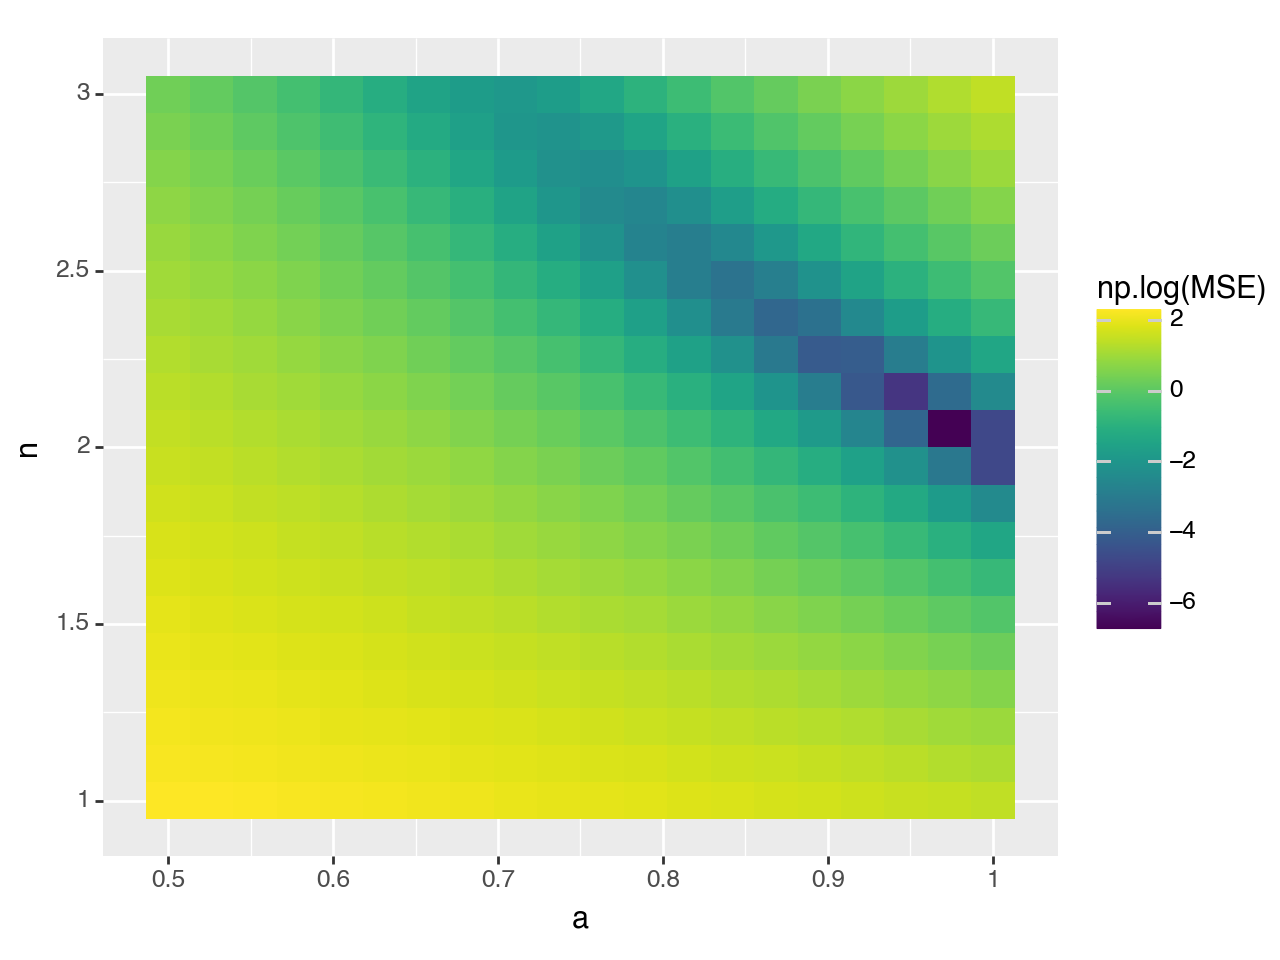

<Figure Size: (640 x 480)>

In [47]:
(
    md_nonlinear
    >> gr.ev_df(
        df=gr.tran_outer(
            df_data 
            >> gr.tf_filter(DF["source"] == "Nonlinear")
            >> gr.tf_rename(f_hat="f"),
            gr.df_grid(a=np.linspace(0.5, +1, 20), n=np.linspace(1, 3, 20))
        )
    )
    >> gr.tf_group_by(DF["a"], DF["n"])
    >> gr.tf_summarize(
        MSE=gr.mse(DF["f_hat"], DF["f"])
    )

    >> gr.ggplot(gr.aes("a", "n"))
    + gr.geom_tile(gr.aes(fill="np.log(MSE)"))
)

## Unidentifiable


In [29]:
md_unidet = (
    gr.Model("Unidentifiabl")
    >> gr.cp_function(
        fun=lambda x, a, b: (a/b) * x,
        var=["x", "a", "b"],
        out=["f"],
    )
    >> gr.cp_bounds(
        x=(-1, +1),
        a=( 1, +4),
        b=( 1, +4),
    )
)

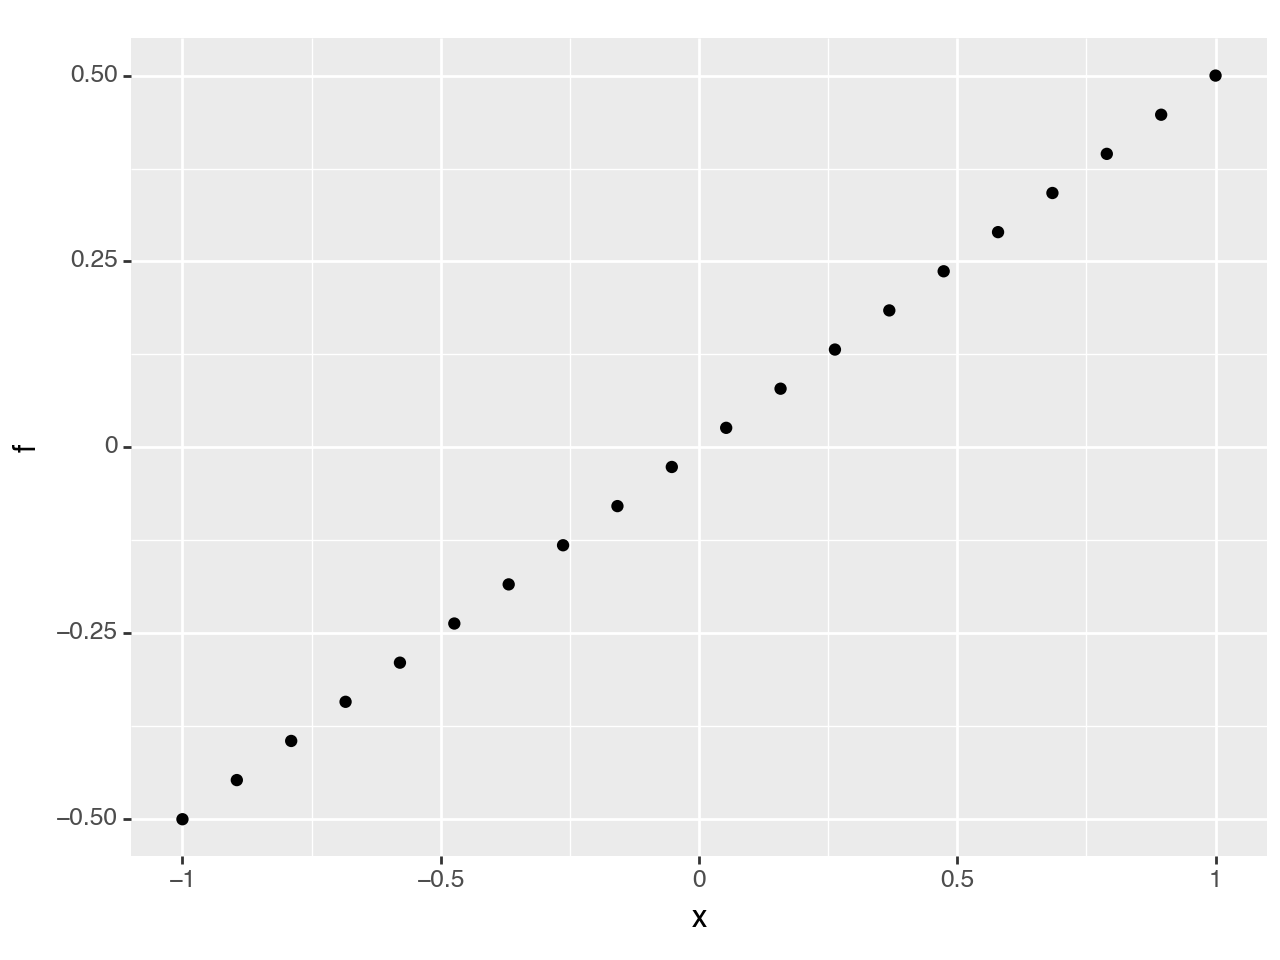

<Figure Size: (640 x 480)>

In [30]:
df_param_unidet = gr.df_make(a=1, b=2)

df_unidet = (
    gr.eval_df(
        md_unidet, 
        df=gr.tran_outer(
            df_param_unidet,
            gr.df_make(x=gr.linspace(-1, +1, 20)),
        )
    )
    >> gr.tf_select("x", "f")
)

(
    df_unidet
    >> gr.ggplot(gr.aes("x", "f"))
    + gr.geom_point()
)

In [31]:
(
    df_unidet
    >> gr.ft_nls(
        md=md_unidet,
    )
)

... fit_nls setting out = ['f']
... eval_nls setting var_fix = []
... eval_nls setting var_feat = {'x'}
Estimated runtime: 0.0000 sec
         a         b  a_0  b_0  success  \
0  1.54414  3.088265  2.5  2.5     True   

                                            message  n_iter           mse  
0  CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL       6  2.027450e-12  


model: Unidentifiabl (Fitted)

  inputs:
    var_det:
      x: (unbounded)

    var_rand:

    copula:
      None

  functions:
      Fix variable levels: ['x'] -> ['a', 'b']
      Unidentifiabl: ['a', 'b', 'x'] -> ['f']

/Users/zach/opt/anaconda3/envs/pdo/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log


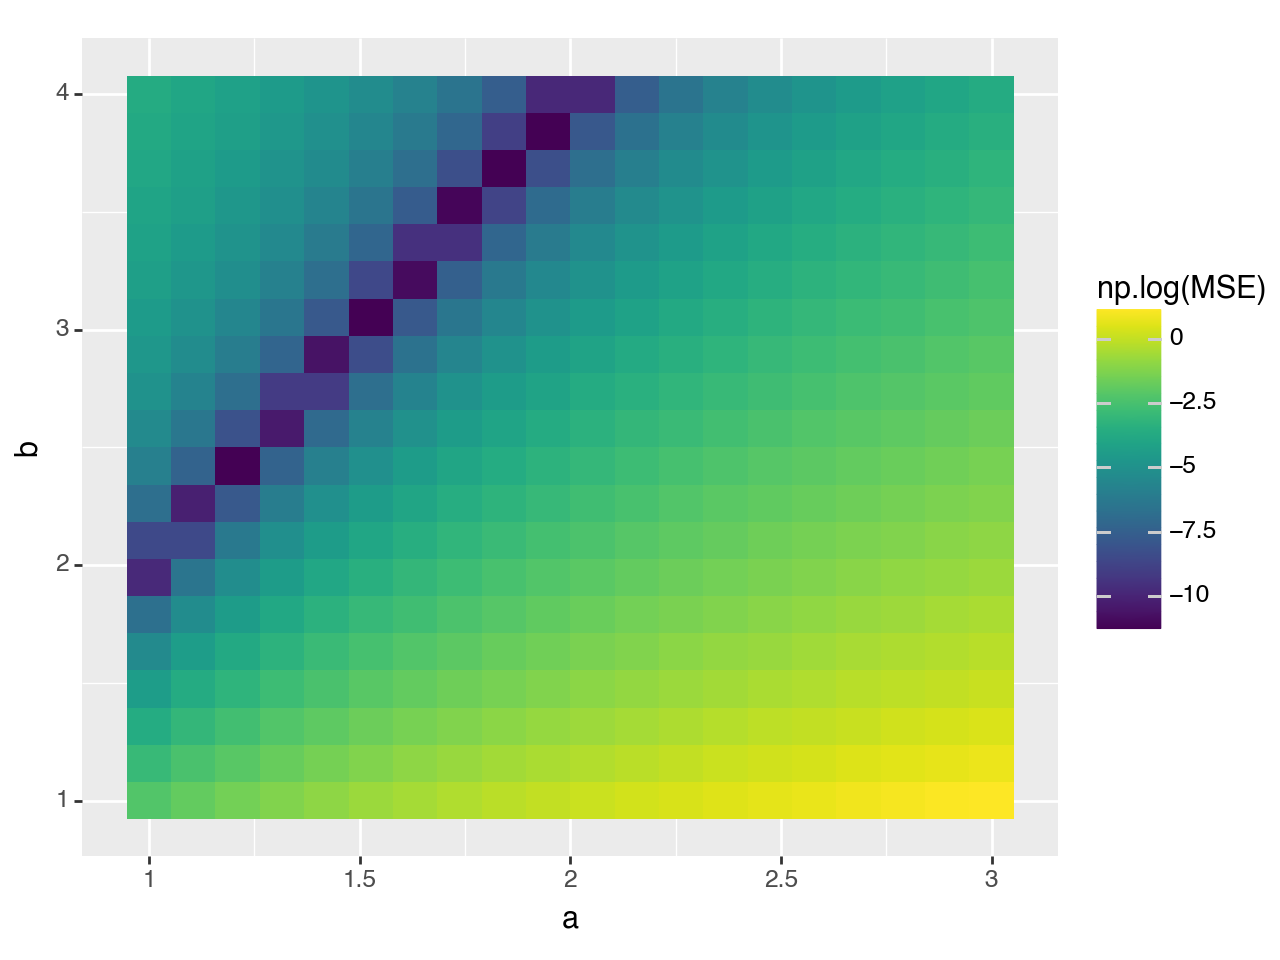

<Figure Size: (640 x 480)>

In [49]:
(
    md_unidet
    >> gr.ev_df(
        df=gr.tran_outer(
            df_unidet >> gr.tf_rename(f_hat="f"),
            gr.df_grid(a=np.linspace(1, 3, 20), b=np.linspace(1, 4, 20))
        )
    )
    >> gr.tf_group_by(DF["a"], DF["b"])
    >> gr.tf_summarize(
        MSE=gr.mse(DF["f_hat"], DF["f"])
    )

    >> gr.ggplot(gr.aes("a", "b"))
    + gr.geom_tile(gr.aes(fill="np.log(MSE)"))
)